In [21]:
# import os
import h5py
import random
import pickle5 as pickle
import numpy as np
import pandas as pd

delta = 1/4
input1_hdf5_filename = 'updeANMO_shift.hdf5'
input1_csv_filename = 'training_PandS_updeANMO_shift.csv'
input1_sample_num = 300
input2_pickle_filename = '/Users/jun/dsm/hotfix_scs.pkl'
output_hdf5_filename = 'updeANMO_shift_syn.hdf5'
output_csv_filename = 'training_PandS_updeANMO_shift_syn.csv'

# os.environ['HDF5_USE_FILE_LOCKING'] = 'FALSE'

# open new hdf5 database
with h5py.File(output_hdf5_filename, 'w') as output_hdf5:

    # load existing hdf5 database and copy-paste to the new
    input1_csv = pd.read_csv(input1_csv_filename)
    sample_table = input1_csv.sample(n=input1_sample_num)
    with h5py.File(input1_hdf5_filename, 'r') as input1_hdf5:
        for index, row in sample_table.iterrows():
            dataset_from = input1_hdf5[f'data/{row["trace_name"]}']
            dataset = output_hdf5.create_dataset(f'data/{row["trace_name"]}', data=dataset_from)
            for key in dataset_from.attrs.keys():
                # if key == 'coda_end_sample': print(dataset_from.attrs[key])
                dataset.attrs[key] = dataset_from.attrs[key]

    # load synthetic seismograms
    with open(input2_pickle_filename, 'rb') as input2_pickle:
        input2_list = pickle.load(input2_pickle)
    
    # write down synthetic seismograms to the new hdf5
    for input2_item in input2_list:
        event_name = f"{input2_item['filepath'].split('/')[-1]}_EV"
        dataset = output_hdf5.create_dataset(f"data/{event_name}",data=input2_item['data'])
        dataset.attrs['p_status'] = 'synthetic'
        dataset.attrs['p_weight'] = 1
        dataset.attrs['p_travel_sec'] = input2_item['p_sample']*delta
        dataset.attrs['p_arrival_sample'] = input2_item['p_sample']
        dataset.attrs['s_status'] = 'synthetic'
        dataset.attrs['s_weight'] = 1
        dataset.attrs['s_arrival_sample'] = input2_item['s_sample']

        coda_end_sample = int((input2_item['ts']-60)/delta)
        waveform_data = input2_item['data'][...]
        snr = (np.sum(abs(waveform_data[int(input2_item['ts']-(10/delta)):int(input2_item['ts']+(50/delta)),:]), axis=0) / (60/delta)) / (np.sum(abs(waveform_data[0:int(40/delta),:]), axis=0) / (40/delta))

        dataset.attrs['coda_end_sample'] = coda_end_sample
        dataset.attrs['snr_db'] = snr
        dataset.attrs['trace_category'] = 'earthquake_local'
        dataset.attrs['network_code'] = input2_item['filepath'].split('/')[-1].split('.')[1]
        dataset.attrs['source_id'] = 'None'
        dataset.attrs['source_distance_deg'] = input2_item['gcarc'] if 'gcarc' in input2_item.keys() else None
        dataset.attrs['source_distance_km'] = input2_item['gcarc'] * 111.1 if 'gcarc' in input2_item.keys() else None
        dataset.attrs['trace_name'] = event_name      
        dataset.attrs['trace_start_time'] = 0
        dataset.attrs['source_magnitude'] = 0
        dataset.attrs['receiver_type'] = 'LH'

        attrs_dict = dict(dataset.attrs)
        attrs_dict['coda_end_sample'] = [[attrs_dict['coda_end_sample']]]
        sample_table = sample_table.append(attrs_dict, ignore_index=True)

# save table to new csv file
sample_table.to_csv(output_csv_filename)

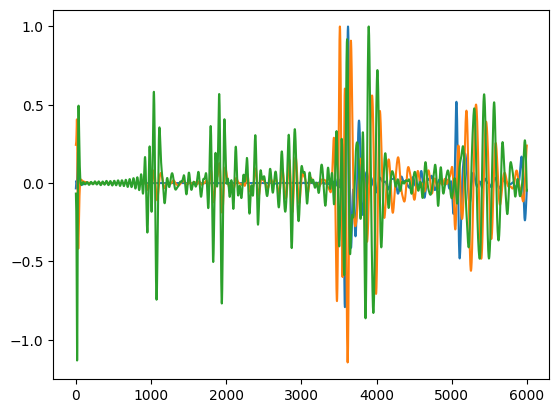

In [50]:
import matplotlib.pyplot as plt
plt.plot(waveform_data)

In [52]:
input2_item['ts']

1427.3247922396472

In [12]:
import pickle5 as pickle
input2_pickle_filename = '/Users/jun/dsm/hotfix_scs.pkl'
with open(input2_pickle_filename, 'rb') as input2_pickle:
    input2_list = pickle.load(input2_pickle)

output_hdf5_filename = 'test_hotfix.hdf5'
delta = 1/4
with h5py.File(output_hdf5_filename, 'w') as output_hdf5:
    input2_item = input2_list[0]
    event_name = f"{input2_item['filepath'].split('/')[-1]}_EV"
    dataset = output_hdf5.create_dataset(f"data/{event_name}",data=input2_item['data'])
    dataset.attrs['p_status'] = 'synthetic'
    dataset.attrs['p_weight'] = 1
    dataset.attrs['p_travel_sec'] = input2_item['p_sample']*delta
    dataset.attrs['p_arrival_sample'] = input2_item['p_sample']
    dataset.attrs['s_status'] = 'synthetic'
    dataset.attrs['s_weight'] = 1
    dataset.attrs['s_arrival_sample'] = input2_item['s_sample']

    code_end_sample = int((input2_item['ts']-60)/delta)
    waveform_data = input2_item['data'][...]
    snr = (np.sum(abs(waveform_data[(input2_item['ts']-(10/delta)):(input2_item['ts']+(50/delta)),:]), axis=0) / (60/delta)) / (np.sum(abs(waveform_data[0:int(40/delta),:]), axis=0) / (40/delta))

    dataset.attrs['coda_end_sample'] = code_end_sample
    dataset.attrs['snr_db'] = snr
    dataset.attrs['trace_category'] = 'earthquake_local'
    dataset.attrs['network_code'] = input2_item['filepath'].split('/')[-1].split('.')[1]
    dataset.attrs['source_id'] = 'None'
    dataset.attrs['source_distance_deg'] = input2_item['gcarc'] if 'gcarc' in input2_item.keys() else None
    dataset.attrs['source_distance_km'] = input2_item['gcarc'] * 111.1 if 'gcarc' in input2_item.keys() else None
    dataset.attrs['trace_name'] = event_name      
    dataset.attrs['trace_start_time'] = 0
    dataset.attrs['source_magnitude'] = None
    dataset.attrs['receiver_type'] = 'LH'

    sample_table = sample_table.append(dict(dataset.attrs), ignore_index=True)

TypeError: slice indices must be integers or None or have an __index__ method

In [67]:
sample_table.iloc[300]

network_code                                                                       GE
receiver_code                                                                     NaN
receiver_type                                                                      LH
receiver_latitude                                                                 NaN
receiver_longitude                                                                NaN
receiver_elevation_m                                                              NaN
p_arrival_sample                                                                 3100
p_status                                                                    synthetic
p_weight                                                                          1.0
p_travel_sec                                                               775.172533
s_arrival_sample                                                                 5709
s_status                                              

In [ ]:
# open new hdf5 database
with h5py.File(output,'w') as f:

    # create datalist by searching all record lists
    datalist = []
    f.create_group("data")

    for event in self.events:
        for trace in event.stations:
            p_status = None
            p_weight = None
            p_travel_sec = None

            for record in trace.records:
                if record.phase == 'P':
                    p_status = 'manual'
                    p_weight = 1/record.error
                    p_calctim0 = event.srctime + record.calctim
                    p_obstim0 = event.srctime + record.obstim

            # s info
            s_status = None
            s_weight = None
            s_travel_sec = None

            for record in trace.records:
                if record.phase == 'S':
                    s_status = 'manual'
                    s_weight = 1/record.error
                    s_obstim0 = event.srctime + record.obstim

            obsfilenames = glob.glob(f"./{loaddir}/{event.srctime}/*{trace.labelsta['name']}.LH.obspy")
            if len(obsfilenames) > 0 and event.srctime > UTCDateTime(1971, 1, 1):
                obsfile_name = obsfilenames[0]
                network_code = obsfile_name.split('/')[-1].split('.')[0]
                event_name = f"{trace.labelsta['name']}.{network_code}_{event.srctime.year:4d}{event.srctime.month:02d}{event.srctime.day:02d}{event.srctime.hour:02d}{event.srctime.minute:02d}{event.srctime.second:02d}_EV"

                stream = read(obsfile_name)

                # sanity check for all three component
                if len(stream) == 3 and len(stream[0])*len(stream[1])*len(stream[2])>0 and np.isscalar(stream[0].data[0]):
                    
                    # check array size for waveform data
                    wrongsize = False
                    for record in stream:
                        if record.data.shape[0] <= 9000+20 and record.data.shape[0] > 9000: record.data = record.data[:9000]
                        elif record.data.shape[0] > 9000+20: print(f"Trace has too many samples: {str(record)}"); wrongsize = True; break
                        elif record.data.shape[0] < 9000: print(f"Trace has too few samples: {str(record)}"); wrongsize = True; break
                    if wrongsize: continue
                    # print(record)
                    
                    try:
                        # preprocessing
                        if preprocess:
                            # get instrument response for waveform station
                            # station_response = InstrumentResponse(network='GE', station='UGM', component='LHZ', start_end_times='2006.180.00.3001.001.00')
                            station_responses = [InstrumentResponse(network=network_code, station=trace.labelsta['name'], component=component, timestamp=event.srctime) for component in ['LHE', 'LHN', 'LHZ']]
                            # station_responses = [InstrumentResponse(network='GE', station='UGM', component='LHZ', start_end_times='2006.180.00.3001.001.00')] * 3
                            
                            # deconvolve and convolve instrument response
                            stream = self.deconvolve(rawdata=stream, station_components=station_responses, reference_components=reference_responses)
                            
                            # calculate azimuth angle
                            azimuth = gps2dist_azimuth(lat1=trace.labelsta['lat'], lon1=trace.labelsta['lon'], lat2=event.srcloc[0], lon2=event.srcloc[1])[2] if rotate is True else 180
                            # azimuth = gps2dist_azimuth(lat1=-7.913, lon1=110.523, lat2=-0.660, lon2=133.430)[2]
                            
                            # rotate to TRZ coordinate
                            stream.rotate('NE->RT', back_azimuth=azimuth)

                            # save data
                            srctime = event.srctime
                            srctime.precision = 3

                            savedir = f"./training/{srctime}"
                            if not os.path.exists(savedir): os.makedirs(savedir)
                            stream.write(f"{savedir}/{network_code}.{trace.labelsta['name']}.LH.obspy", format="PICKLE")

                        # resampling
                        shift_range = random.randrange(shift[0],shift[1]+1)
                        if resample != 0:
                            shift_bit = random.randrange(resample)
                            delta = 1/resample
                            stream.trim(starttime=fn_starttime_train(p_calctim0+shift_range), endtime=fn_endtime_train(p_calctim0+shift_range+1))
                            stream.interpolate(sampling_rate=resample, method='lanczos', a=20)
                            if len(stream) == 3:
                                stdshape = (int(1500*resample), 3)
                                waveform_data = np.transpose([np.array(stream[0].data[shift_bit:], dtype=np.float32), np.array(stream[1].data[shift_bit:], dtype=np.float32), np.array(stream[2].data[shift_bit:], dtype=np.float32)]) 
                                if waveform_data.shape[0] <= int(1520*resample) and waveform_data.shape[0] > int(1500*resample): waveform_data = waveform_data[:int(1500*resample),0:3]
                        else:
                            shift_bit = 0
                            delta = 1
                            stream.trim(starttime=p_calctim0-100+shift_range, endtime=p_calctim0+1400+shift_range)
                            stdshape = (1500, 3)
                            if len(stream) == 3:
                                waveform_data = np.transpose([np.array(stream[0].data, dtype=np.float64), np.array(stream[1].data, dtype=np.float64), np.array(stream[2].data, dtype=np.float64)]) 
                                if waveform_data.shape[0] <= 1520 and waveform_data.shape[0] > 1500: waveform_data = waveform_data[:1500,0:3]

                        # check for problematic values in array
                        waveform_data = waveform_data.astype(np.float32)
                        anynan = np.isnan(waveform_data).any()
                        # conditions = ((p_status or s_status) and waveform_data.shape==stdshape and not anynan)
                        conditions = (p_status and s_status and waveform_data.shape==stdshape and not anynan)

                        if conditions:
                            dataset = f.create_dataset(f"data/{event_name}",data=waveform_data)
                            if p_status:
                                p_travel_sec = p_obstim0 - fn_starttime_train(p_calctim0 + shift_range) - shift_bit * delta
                                dataset.attrs['p_arrival_sample'] = int(p_travel_sec/delta)
                                dataset.attrs['p_status'] = p_status
                                dataset.attrs['p_weight'] = p_weight
                                dataset.attrs['p_travel_sec'] = p_travel_sec
                            if s_status:
                                s_travel_sec = s_obstim0 - fn_starttime_train(p_calctim0 + shift_range) - shift_bit * delta
                                dataset.attrs['s_arrival_sample'] = int(s_travel_sec/delta)
                                dataset.attrs['s_status'] = s_status
                                dataset.attrs['s_weight'] = s_weight
                                code_end_sample = int((s_travel_sec-60)/delta)
                                snr = (np.sum(abs(waveform_data[int((s_travel_sec-10)/delta):int((s_travel_sec+50)/delta),:]), axis=0) / (60/delta)) / (np.sum(abs(waveform_data[0:int(40/delta),:]), axis=0) / (40/delta))
                            else:
                                code_end_sample = int((p_travel_sec+400)/delta)
                                snr = (np.sum(abs(waveform_data[int((p_travel_sec+20)/delta):int((p_travel_sec+400)/delta),:]), axis=0) / (380/delta)) / (np.sum(abs(waveform_data[0:int(40/delta),:]), axis=0) / (40/delta)) 
                            
                            dataset.attrs['coda_end_sample'] = code_end_sample
                            dataset.attrs['snr_db'] = snr
                            dataset.attrs['trace_category'] = 'earthquake_local'
                            dataset.attrs['network_code'] = network_code
                            dataset.attrs['source_id'] = 'None'
                            dataset.attrs['source_distance_km'] = trace.labelsta['dist'] * 111.1
                            dataset.attrs['trace_name'] = event_name      
                            dataset.attrs['trace_start_time'] = str(event.srctime)
                            dataset.attrs['source_magnitude'] = 0
                            dataset.attrs['receiver_type'] = 'LH'
                            datalist.append({'network_code': network_code, 'receiver_code': trace.labelsta['name'], 'receiver_type': 'LH', 'receiver_latitude': trace.labelsta['lat'], 'receiver_longitude': trace.labelsta['lon'], 'receiver_elevation_m': None, 'p_arrival_sample': int(p_travel_sec/delta) if p_status else None, 'p_status': p_status, 'p_weight': p_weight, 'p_travel_sec': p_travel_sec, 's_arrival_sample': int(s_travel_sec/delta) if s_status else None, 's_status': s_status, 's_weight': s_weight, 'source_id': None, 'source_origin_time': event.srctime, 'source_origin_uncertainty_sec': None, 'source_latitude':event.srcloc[0], 'source_longitude': event.srcloc[1], 'source_error_sec': None, 'source_gap_deg': None, 'source_horizontal_uncertainty_km': None, 'source_depth_km': event.srcloc[2], 'source_depth_uncertainty_km': None, 'source_magnitude': None, 'source_magnitude_type': None, 'source_magnitude_author': None, 'source_mechanism_strike_dip_rake': None, 'source_distance_deg': trace.labelsta['dist'], 'source_distance_km': trace.labelsta['dist'] * 111.1, 'back_azimuth_deg': trace.labelsta['azi'], 'snr_db': snr, 'coda_end_sample': [[code_end_sample]], 'trace_start_time': event.srctime, 'trace_category': 'earthquake_local', 'trace_name': event_name})
                    except ValueError as e:
                        print(f"Value error for {obsfile_name}: {e}")
                    # except:
                    #     print(f"Unexpect error for {obsfile_name}")
